# Ensemble statistics

This notebook presents functions designed to work with simulation ensembles. 

In [1]:
%matplotlib inline
import glob
import matplotlib.pyplot as plt
import logging 
mpl_logger = logging.getLogger('matplotlib') 
mpl_logger.setLevel(logging.WARNING) 

# XCLIM and xarray
import numpy as np
import xarray as xr
import dask
from distributed import Client

## 1. Set up Dask client - Parallel processing / workers

In [2]:
# start client
client=Client(n_workers=2, threads_per_worker=10, dashboard_address=8788, ip='0.0.0.0', memory_limit='10GB')
client

Client Scheduler: tcp://127.0.0.1:39714 Dashboard: http://127.0.0.1:8788/status,Cluster Workers: 2 Cores: 20 Memory: 20.00 GB


## Ensemble creation & analysis
**Use precalculated annual tx_max index using bias-corrected climate scenarios**

In [3]:
# create dictionary with list of rcp 4.5 and 8.5 files
inrep = '/scen3/logan/testdata/XCLIM_workshop/ensemble_data/'
rcps = ['rcp45','rcp85']
v = 'tx_max'
ncfiles = {}
for r in rcps:
    ncfiles[r] = glob.glob(glob.os.path.join(inrep,r,v,'*.nc'))
print(ncfiles[r])

['/scen3/logan/testdata/XCLIM_workshop/ensemble_data/rcp85/tx_max/tx_max_YS_day_ACCESS1-3_rcp85_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.nc', '/scen3/logan/testdata/XCLIM_workshop/ensemble_data/rcp85/tx_max/tx_max_YS_day_BNU-ESM_rcp85_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.nc', '/scen3/logan/testdata/XCLIM_workshop/ensemble_data/rcp85/tx_max/tx_max_YS_day_CMCC-CMS_rcp85_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.nc', '/scen3/logan/testdata/XCLIM_workshop/ensemble_data/rcp85/tx_max/tx_max_YS_day_CanESM2_rcp85_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.nc', '/scen3/logan/testdata/XCLIM_workshop/ensemble_data/rcp85/tx_max/tx_max_YS_day_GFDL-ESM2M_rcp85_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.nc', '/scen3/logan/testdata/XCLIM_workshop/ensemble_data/rcp85/tx_max/tx_max_YS_day_HadGEM2-CC_rcp85_r1i1p1_na10kgrid_qm-moving-50bins-detrend_1950-2100.nc', '/scen3/logan/testdata/XCLIM_workshop/ensemble_data/rcp85/tx_max/tx_max_YS_day_INM-CM4_rcp

### 1. Create ensemble dataset - concatenation of overlapping time-steps of the different models along a new axis 'realization'

Using `xarray` a very simple way of creating an ensemble dataset would be :
```python
open_mfdataset(files, concat_dim='ensemble') 
```

However, this is only successful when the dimensions of all the files are identical AND only if the calendar type of each netcdf file is the same

xclim's `create_ensemble()` function overcomes these constraints selecting the common time period to all files and assigns a standard calendar type to the dataset. 

-----
Notes

Input netcdf files still require equal spatial dimension size (e.g. lon, lat dimensions) <br />
If input data contains multiple cftime calendar types they must not be at daily frequency

In [4]:
from xclim import ensembles as xens
print('Creating RCP 4.5 ensemble')
ens_rcp45 = xens.create_ensemble(ncfiles['rcp45'])
print('\nCreating RCP 8.5 ensemble')
ens_rcp85 = xens.create_ensemble(ncfiles['rcp85'])

  FutureWarning)



Creating RCP 4.5 ensemble
finding common time-steps
accessing file  1  of  11
accessing file  2  of  11
accessing file  3  of  11
accessing file  4  of  11
accessing file  5  of  11
accessing file  6  of  11
accessing file  7  of  11
accessing file  8  of  11
accessing file  9  of  11
accessing file  10  of  11
accessing file  11  of  11
concatenating files : adding dimension  realization

Creating RCP 8.5 ensemble
finding common time-steps
accessing file  1  of  11
accessing file  2  of  11
accessing file  3  of  11
accessing file  4  of  11
accessing file  5  of  11
accessing file  6  of  11
accessing file  7  of  11
accessing file  8  of  11
accessing file  9  of  11
accessing file  10  of  11
accessing file  11  of  11
concatenating files : adding dimension  realization


### 2. Ensemble data sets have an additional dimension 'realization'

In [5]:
print('RCP 4.5 dataset dimensions: \t', ens_rcp45.tx_max.dims)
print('RCP 4.5 dataset size: \t\t', ens_rcp45.tx_max.shape)

RCP 4.5 dataset dimensions: 	 ('realization', 'time', 'lat', 'lon')
RCP 4.5 dataset size: 		 (11, 151, 180, 324)


### 3. Simple plots
-----
**Time series plot of each simulation : Average of spatial domain ['lon','lat']**


To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)



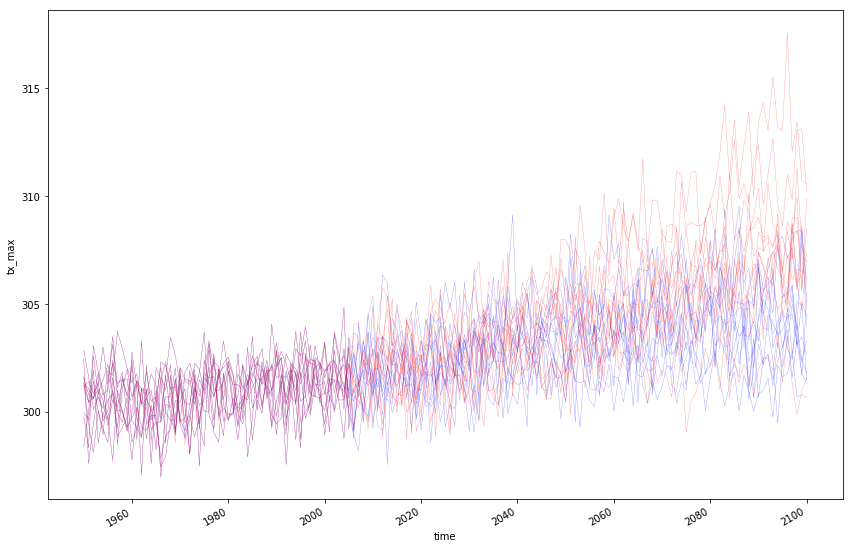

In [6]:
plt.rcParams['figure.figsize'] = [9.5*1.5, 6*1.5]
ens_rcp45['tx_max'].mean(['lon', 'lat']).plot.line(x='time', color='blue', lw=0.3, alpha=.5, add_legend=False)
ens_rcp85['tx_max'].mean(['lon', 'lat']).plot.line(x='time', color='red', lw=0.3, alpha=.5, add_legend=False)

### 4. Ensemble statistics
Beyond creating ensemble dataset the `xclim.ensembles` module contains functions for calculating statistics between realizations

**Ensemble mean, standard-deviation, max & min**

In the example below we use xclim's `ensemble_mean_std_max_min()` to calculate statistics across the 11 realizations in our test dataset. Output variables are created combining the original variable name `tx_max` with addtional ending indicating the statistic calculated on the realization dimension : `_mean`, `_stdev`, `_min`, `_max`

The resulting output now contains 4 derived variables from the original single variable in our ensemble dataset

In [7]:
ens_stats = {}
ens_stats['rcp85'] = xens.ensemble_mean_std_max_min(ens_rcp85)
ens_stats['rcp45'] = xens.ensemble_mean_std_max_min(ens_rcp45)
print(ens_stats['rcp85'].data_vars)


Data variables:
    tx_max_mean   (time, lat, lon) float32 dask.array<shape=(151, 180, 324), chunksize=(10, 180, 324)>
    tx_max_stdev  (time, lat, lon) float32 dask.array<shape=(151, 180, 324), chunksize=(10, 180, 324)>
    tx_max_max    (time, lat, lon) float32 dask.array<shape=(151, 180, 324), chunksize=(10, 180, 324)>
    tx_max_min    (time, lat, lon) float32 dask.array<shape=(151, 180, 324), chunksize=(10, 180, 324)>


**Ensemble time-series figures**

Using `matplotlib` we can employ the `fill_between()` function to create our classic ensemble time-series figures 

distributed.nanny - WARNING - Worker process 27681 was killed by unknown signal
distributed.nanny - WARNING - Restarting worker


Text(0, 0.5, 'K')

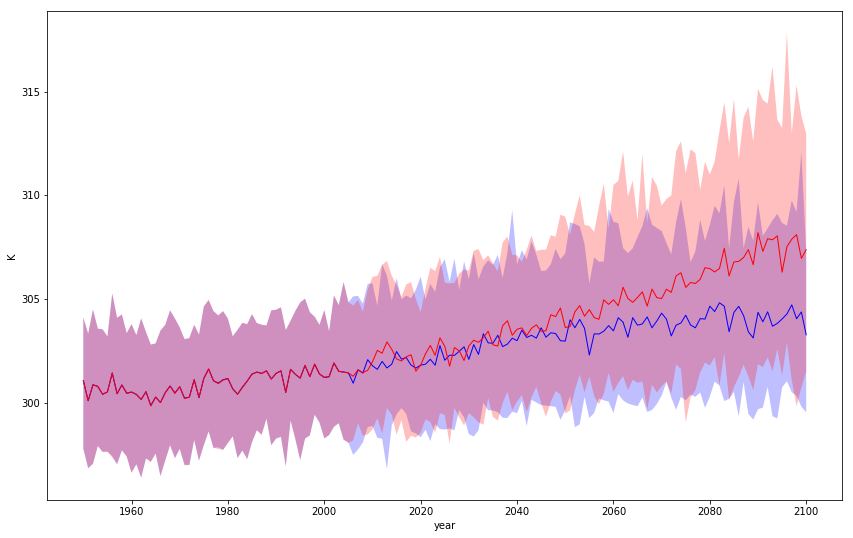

In [8]:
plt.rcParams['figure.figsize'] = [9.5*1.5, 6*1.5]
for r in rcps:
    if 'rcp45' in r:
        col1 = 'blue'
    else:
        col1 = 'red'
    # Uncertainty Envelope (max, min)
    x = ens_stats[r]['tx_max_mean'].time.dt.year
    y1 = ens_stats[r]['tx_max_max'].mean(['lon','lat'])
    y2 = ens_stats[r]['tx_max_min'].mean(['lon','lat'])
    plt.fill_between(x,y1,y2, facecolor = col1, alpha = 0.25)
    
    # Plot ensemble mean
    plt.plot(x,ens_stats[r]['tx_max_mean'].mean(['lon','lat']), color=col1, linewidth = 1)
plt.xlabel('year')
plt.ylabel(ens_rcp45[v].units)

### 4b. Ensemble percentiles

**Ensemble percentile calculation**

Here we use xclim's `ensemble_percentiles()` to calculate percentile values across the 11 realizations. 
Output variables are created for combining the original variable name `tx_max` with the addtional ending `_p{x}` where x are the input percentile values `default = [10, 50, 90]`

In [9]:
ens_perc = {}
ens_perc['rcp85'] = xens.ensemble_percentiles(ens_rcp85)
ens_perc['rcp45'] = xens.ensemble_percentiles(ens_rcp45)
print(ens_perc['rcp85'].data_vars)

loading ensemble data to memory


  interpolation=interpolation)



loading ensemble data to memory
Data variables:
    tx_max_p10  (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    tx_max_p50  (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    tx_max_p90  (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan


Text(0, 0.5, 'K')

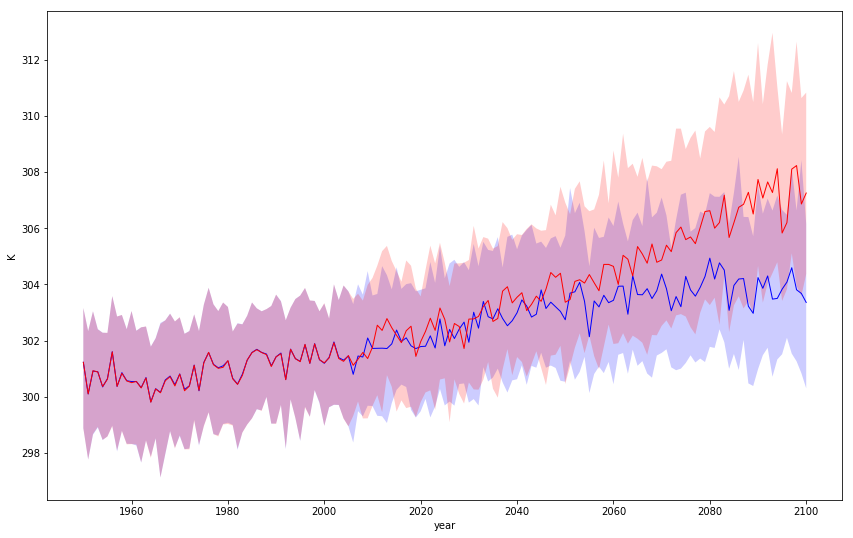

In [10]:
plt.rcParams['figure.figsize'] = [9.5*1.5, 6*1.5]

for r in rcps:
    if 'rcp45' in r:
        col1 = 'blue'
    else:
        col1 = 'red'
        
    #Uncertainty 10-90th band
    y1 = ens_perc[r]['tx_max_p90'].mean(['lon','lat'])
    y2 = ens_perc[r]['tx_max_p10'].mean(['lon','lat'])
    plt.fill_between(x,y1,y2, facecolor=col1, alpha=0.2)

    plt.plot(x,ens_perc[r]['tx_max_p50'].mean(['lon','lat']), color=col1, linewidth = 1)
plt.xlabel('year')
plt.ylabel(ens_rcp45[v].units)

**User's can optionally use custom percentile values**

In [11]:
ens_perc = {}
ens_perc['rcp85'] = xens.ensemble_percentiles(ens_rcp85, values=[10,25,50,75,90])
ens_perc['rcp45'] = xens.ensemble_percentiles(ens_rcp45, values=[10,25,50,75,90])
print(ens_perc['rcp85'].data_vars)

loading ensemble data to memory
loading ensemble data to memory
Data variables:
    tx_max_p10  (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    tx_max_p25  (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    tx_max_p50  (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    tx_max_p75  (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    tx_max_p90  (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan


**Subplot by RCP**

Plot with double uncertainty bands (10<sup>th</sup> to 90<sup>th</sup> & 25<sup>th</sup> to 75<sup>th</sup>)

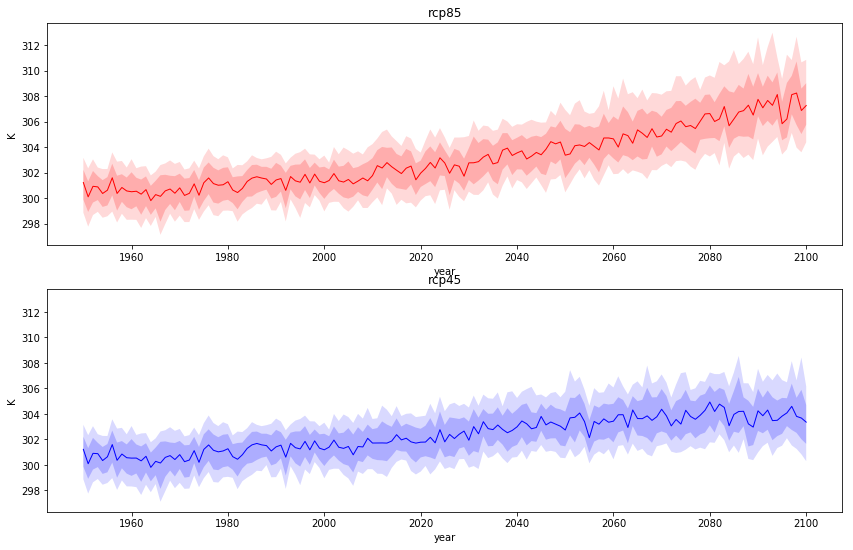

In [12]:
plt.rcParams['figure.figsize'] = [9.5*1.5, 6*1.5]
ax = {}
ylim_vals = []
for r in rcps:
    
    if 'rcp45' in r:
        col1 = 'blue'
        ax[r] = plt.subplot(212)
    else:
        col1 = 'red'
        ax[r] = plt.subplot(211)
        
    #Uncertainty 10-90th band
    y1 = ens_perc[r]['tx_max_p90'].mean(['lon','lat'])
    y2 = ens_perc[r]['tx_max_p10'].mean(['lon','lat'])
    plt.fill_between(x,y1,y2, facecolor=col1, alpha=0.15)
    
    #Uncertainty 25th-75th band
    y1 = ens_perc[r]['tx_max_p75'].mean(['lon','lat'])
    y2 = ens_perc[r]['tx_max_p25'].mean(['lon','lat'])
    plt.fill_between(x,y1,y2, facecolor=col1, alpha=0.2)
    plt.plot(x,ens_perc[r]['tx_max_p50'].mean(['lon','lat']), color=col1, linewidth = 1)
    plt.title(r)
    plt.xlabel('year')
    plt.ylabel(ens_perc[r]['tx_max_p50'].units)
    ylim_vals.extend(ax[r].get_ylim())
    
    

# Adjust y-axis to common values
for r in rcps:
    ax[r].set_ylim(np.min(ylim_vals), np.max(ylim_vals))

### 5. Climatologies and delta calculations

`xarray` has many ways to allow us to select and average data.  
The following example employ `rolling()` in order to create 30 year moving averages and `sel()` for selecting time periods

Other `xarray` functions that could potentially be use include `coarsen()` or `groupby()`  
http://xarray.pydata.org/en/stable/generated/xarray.DataArray.coarsen.html?highlight=coarsen  
http://xarray.pydata.org/en/stable/groupby.html

In [13]:
# 30 year averages
ens30y = ens_rcp85.rolling(time=30,  center=False).mean()
print(ens30y)

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 324, realization: 11, time: 151)
Coordinates:
  * lat      (lat) float64 59.96 59.87 59.79 59.71 ... 45.29 45.21 45.12 45.04
  * lon      (lon) float64 -81.96 -81.88 -81.8 -81.71 ... -55.21 -55.13 -55.05
  * time     (time) datetime64[ns] 1950-01-01 1951-01-01 ... 2100-01-01
Dimensions without coordinates: realization
Data variables:
    tx_max   (realization, time, lat, lon) float32 nan nan nan ... nan nan nan


-----
Notes - with center==False the output dates represents the end of the moving average

### Selecting reference period : 1981-2010 
The `xarray.DataArray.sel()` method is a convenient way to select data.  
Here we select the 1981-2010 average from our data simply using a datestring without having to use traditional indexing 

see http://xarray.pydata.org/en/stable/indexing.html for more info on selecting and indexing data with `xarray`

In [14]:
# select reference period 
ref_per = ens30y.sel(time='2010-01-01')
print(ref_per['tx_max'].dims)
print(ref_per['tx_max'].shape)

('realization', 'lat', 'lon')
(11, 180, 324)


### Mapping the 1981-2010 average for a single model
The `isel()` method is another `xarray` selection method. It still relies on indexes but without needing to know the dimension order 

Here we display the reference period values for the first model  of the ensemble (index == 0)

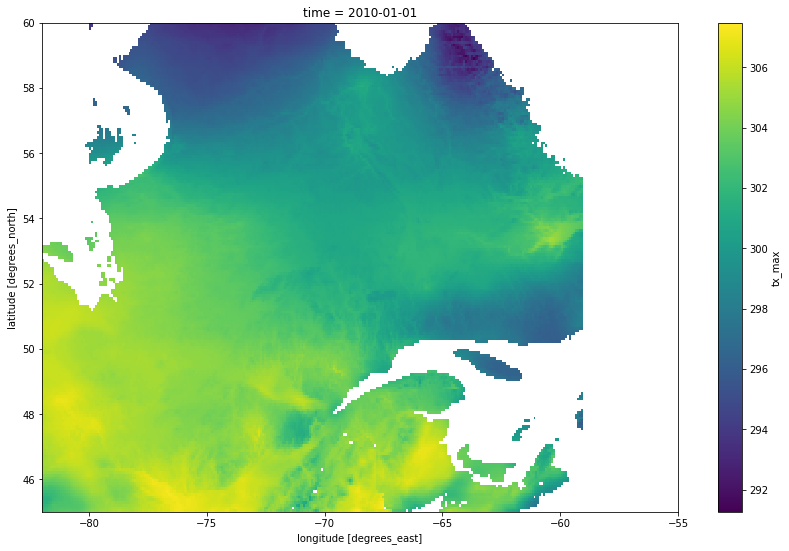

In [15]:
# map of single model
ref_per['tx_max'].isel(realization=0).plot.imshow()

### Calculate delta values 
 
substracting our reference `ref_per` from our 30 year moving averages `ens30y` will calculate delta values for all moving windows and all (n=11) models in a single step

In [16]:
ensDeltas = ens30y - ref_per
print(ensDeltas.data_vars)

Data variables:
    tx_max   (realization, time, lat, lon) float32 nan nan nan ... nan nan nan


**Ensemble statistics on 30 year deltas**  

In [17]:
ens_percDeltas = xens.ensemble_percentiles(ensDeltas)
print(ens_percDeltas.data_vars)

loading ensemble data to memory
Data variables:
    tx_max_p10  (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    tx_max_p50  (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    tx_max_p90  (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan


**Map of ensemble median delta RCP 8.5 : 2071-2100 vs 1981-2010**

Text(0.5, 1.0, 'Delta tx_max 2071-2100 versus 1981-2010 : RCP 8.5')

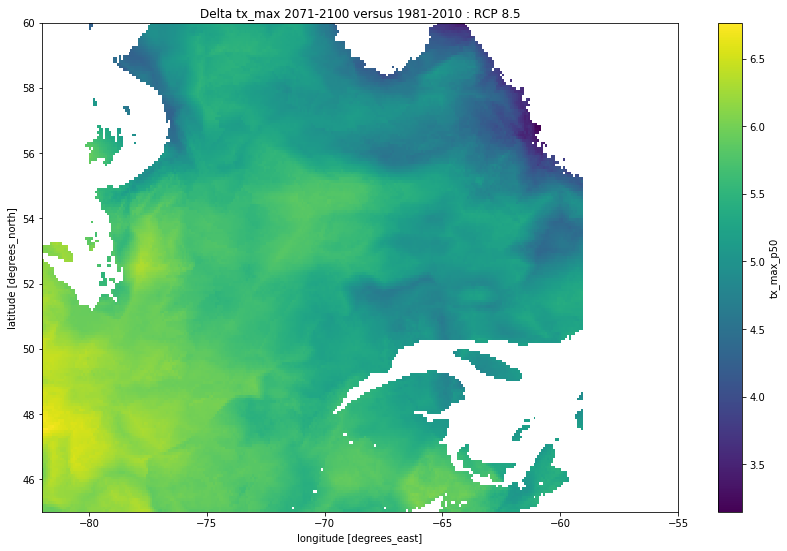

In [18]:
ens_percDeltas['tx_max_p50'].sel(time='2100-01-01').plot.imshow()
plt.title('Delta tx_max 2071-2100 versus 1981-2010 : RCP 8.5')